In [1]:
#John Gizis
#Plot parallax observations for a given LSST simulation. adopted from Peter Yoachim's code at https://github.com/yoachim/LSST-BD-Cadence/blob/main/Pass_example.ipynb

#note this uses rubin_sim 

#The worst (from our point of view) of the V1.7 twilight NEO surveys

In [2]:

import rubin_sim.maf.utils as mafUtils

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
import rubin_sim.maf.plots as plots
import rubin_sim.maf.maps as maps


In [3]:
#choose location for plotting

#random spot in main survey
ra0=0
dec0=-20

# ...or...
#ra0=9.45
#dec0= -44
#This is a deep drilling field! ELIAS-S1

#or COSMOS DDF
#ra0=150.1
#dec0= 2.18

In [4]:
dbFile = '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern1_v1.7_10yrs.db' 
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='illustrate'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
bundleList = []
#sql = 'filter="z" or filter="y"'
sql = 'visitExposureTime > 14.'
metric = metrics.PassMetric(cols=['filter', 'fiveSigmaDepth', 'ra_pi_amp',
                                  'dec_pi_amp', 'seeingFwhmGeom','observationStartMJD'
                                 ])
slicer = slicers.UserPointsSlicer(ra=ra0, dec=dec0)
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             runName=runName))


In [6]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database SummaryAllProps with constraint visitExposureTime > 14. for columns ['fieldDec', 'filter', 'seeingFwhmGeom', 'rotSkyPos', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA']
Found 1833424 visits
Running:  ['_sims_maf_fbs_1_7_twi_neo_twi_neo_pattern1_v1_7_10yrs_Pass_filter_fiveSigmaDepth_ra_pi_amp_dec_pi_amp_seeingFwhmGeom_observationStartMJD_visitExposureTime_gt_14_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [7]:
bundleList[0].metricValues[0].dtype
dataSlice = bundleList[0].metricValues[0]

In [8]:
dataSlice.dtype


dtype([('fieldDec', '<f8'), ('filter', '<U256'), ('seeingFwhmGeom', '<f8'), ('rotSkyPos', '<f8'), ('fiveSigmaDepth', '<f8'), ('observationStartMJD', '<f8'), ('fieldRA', '<f8'), ('ra_pi_amp', '<f8'), ('dec_pi_amp', '<f8')])

In [9]:
# Here's the parallax amplitude. I'll just assume a 1" parallax star, but could multiply by any factor.
parallax_amplitude = (dataSlice['ra_pi_amp']**2 + dataSlice['dec_pi_amp']**2)**0.5
star_mag = 20.  # Just assume a flat SED. This is used in the estimate of the uncertainty.
snr = parallax_amplitude*0
atm_err = 0.01

for filt in np.unique(dataSlice['filter']):
    good = np.where(dataSlice['filter'] == filt)
    snr[good] = mafUtils.m52snr(star_mag, dataSlice['fiveSigmaDepth'][good])
position_errors = np.sqrt(mafUtils.astrom_precision(dataSlice['seeingFwhmGeom'],
                                                            snr)**2+atm_err**2)

Text(0, 0.5, 'Parallax Amplitude (arcsec)')

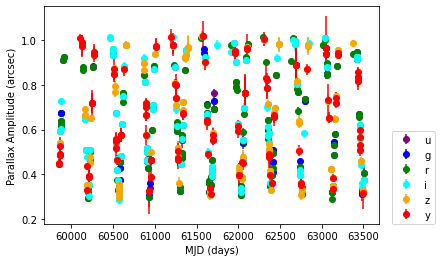

In [10]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filt in 'ugrizy':
    good = np.where(dataSlice['filter'] == filt)
    plt.errorbar(dataSlice['observationStartMJD'][good], parallax_amplitude[good], yerr=position_errors[good],
                color=f2c[filt], fmt='o', label=filt)
plt.legend(loc=(1.04,0))
plt.xlabel('MJD (days)')
plt.ylabel('Parallax Amplitude (arcsec)')

In [11]:
izy = np.where((dataSlice['filter'] == 'z')|(dataSlice['filter'] == 'y'))
iz = np.where(dataSlice['filter'] == 'z')
iy = np.where(dataSlice['filter'] == 'y')
            

In [12]:
plot_base = """plot_twi_bad_{plottype}_{ra}_{dec}.{ftype}"""


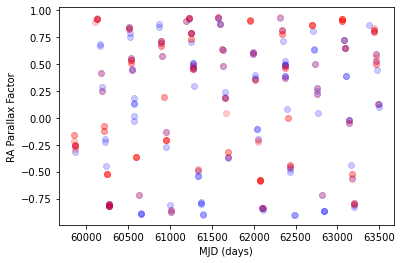

In [13]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='blue',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')   
plotname=plot_base.format(plottype='MJD_RAP',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)

In [14]:
days_since_start = dataSlice['observationStartMJD'] - np.min(dataSlice['observationStartMJD'])
years_since_start = days_since_start / 365.25636        #am I using right length of year? 
phase_years = years_since_start % 1

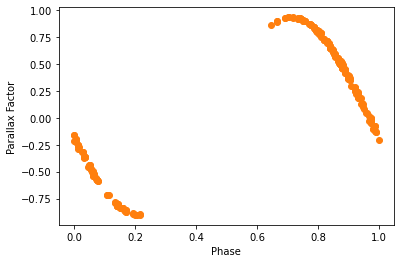

In [15]:
plt.plot(phase_years[izy],dataSlice['ra_pi_amp'][izy],'o',color='C1')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor')   
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)


In [16]:
np.size(dataSlice['ra_pi_amp'][izy])

294

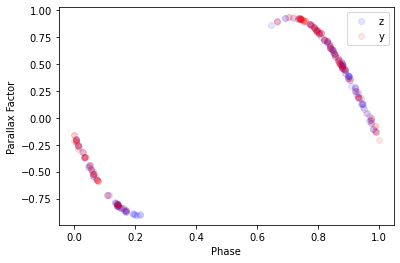

In [17]:
plt.plot(phase_years[iz],dataSlice['ra_pi_amp'][iz],'o',color='blue',alpha=0.1,label='z')
plt.plot(phase_years[iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.1,label='y')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor');
plt.legend()
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)



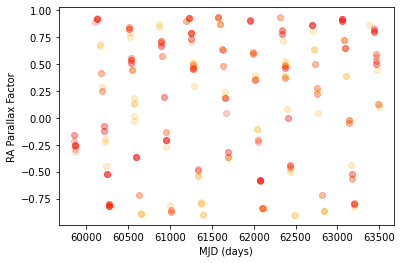

In [18]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='orange',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')  
plotname=plot_base.format(plottype='MJD_RAP_zy',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)




In [19]:
print(np.max(dataSlice['ra_pi_amp'][iy]),np.min(dataSlice['ra_pi_amp'][iy]))

0.9360702670601645 -0.8726755725245078


In [20]:
from astropy.table import QTable, Table, Column
from astropy import units as u

In [21]:
parallax_table = Table()
parallax_table['MJD'] = dataSlice['observationStartMJD'][izy]
parallax_table['ra_pi_amp'] = dataSlice['ra_pi_amp'][izy]
parallax_table['dec_pi_amp'] = dataSlice['dec_pi_amp'][izy]
parallax_table['filter'] = dataSlice['filter'][izy]
parallax_table['seeingFWHM'] = dataSlice['seeingFwhmGeom'][izy]
parallax_table['snr'] = snr[izy]
parallax_table['position_errors'] = position_errors[izy]
parallax_table['fiveSigmaDepth'] = dataSlice['fiveSigmaDepth'][izy]
parallax_table['fieldRA'] = dataSlice['fieldRA'][izy]
parallax_table['fieldDec'] = dataSlice['fieldDec'][izy]




In [22]:
parallax_table

MJD,ra_pi_amp,dec_pi_amp,filter,seeingFWHM,snr,position_errors,fiveSigmaDepth,fieldRA,fieldDec
float64,float64,float64,str256,float64,float64,float64,float64,float64,float64
62840.05455658067,-0.8696351134824756,-0.4479075157526547,z,1.2627354636226322,38.25648931785153,0.03448866660533674,22.209337773236562,359.0274535976268,-20.946077074027745
61275.220379326245,0.45669807800924683,-0.12911310566982998,z,0.9176636949790206,63.87308605403591,0.017504578531580568,22.76586973860692,358.99965606672896,-21.240348341718263
63085.35006822299,0.6528976393761862,0.010205268664305808,z,1.0326394277396793,48.145337424486925,0.023665015256586357,22.45896057612574,358.97373683913924,-21.031831033968135
63085.29919688979,0.6534660590300037,0.010645353861641574,y,0.6368481357113953,44.69816403500271,0.01740684625659834,22.37829920158473,358.97373683913924,-21.031831033968135
63085.28250161996,0.653652501666175,0.0107897815842537,z,0.7310406753349026,69.3363080831263,0.014531460971849153,22.854976772329216,358.97373683913924,-21.031831033968135
63085.36664566958,0.6527123043574283,0.010061855976400665,y,0.7813787010482068,34.91652028979219,0.024511149122307486,22.110152379847886,358.97373683913924,-21.031831033968135
61993.38455432717,0.6149703261470852,-0.020635026603196705,z,0.7652302236419716,63.46090645505843,0.015665325962378886,22.758840666986412,359.18416804016476,-20.964163849668623
62368.21243738142,0.49264852405388854,-0.11673397165893216,z,1.0056353422170055,54.76951570305452,0.02090776277153454,22.598922240951474,359.1947710764776,-21.82589522439484
60567.1576418878,0.13888352656394656,-0.3106312286718029,z,0.8102823709238582,67.92003416621229,0.015566747330576374,22.832569728414068,359.9290515003159,-21.78170438627262


In [23]:
from astropy.io import ascii

In [24]:
out_base = """data_twi_bad_{datatype}_{ra}_{dec}.{ftype}"""
outname_tbl=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='tbl')
outname_csv=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='csv')


In [25]:
#ascii.write(parallax_table,outname_tbl,format='ipac')

In [26]:
ascii.write(parallax_table,outname_csv,format='ecsv')

(array([1.03597243, 0.4809872 , 0.14799606, 0.36999015, 0.51798621,
        0.36999015, 0.25899311, 0.4809872 , 0.29599212, 0.36999015,
        0.18499508, 0.44398818, 0.33299114, 0.25899311, 0.70298129,
        0.9619744 , 0.70298129, 0.59198424, 0.81397834, 1.55395864]),
 array([-0.90255194, -0.81062083, -0.71868972, -0.6267586 , -0.53482749,
        -0.44289638, -0.35096527, -0.25903416, -0.16710305, -0.07517194,
         0.01675917,  0.10869028,  0.20062139,  0.2925525 ,  0.38448361,
         0.47641472,  0.56834583,  0.66027694,  0.75220805,  0.84413916,
         0.93607027]),
 [<matplotlib.patches.Polygon at 0x7f6f295d0490>])

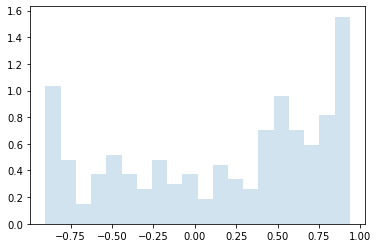

In [27]:
plt.hist(parallax_table['ra_pi_amp'],bins=20,histtype='stepfilled', alpha=0.2, density=True)


(array([0.00632657, 0.01546496, 0.02179153, 0.0267122 , 0.0253063 ,
        0.01405905, 0.01546496, 0.00773248, 0.01405905, 0.00702953,
        0.01265315, 0.00913838, 0.00562362, 0.00632657, 0.00632657,
        0.00281181, 0.00421772, 0.00281181, 0.00210886, 0.00070295]),
 array([ 13.72689507,  18.56557143,  23.40424779,  28.24292415,
         33.08160051,  37.92027687,  42.75895323,  47.5976296 ,
         52.43630596,  57.27498232,  62.11365868,  66.95233504,
         71.7910114 ,  76.62968776,  81.46836412,  86.30704048,
         91.14571685,  95.98439321, 100.82306957, 105.66174593,
        110.50042229]),
 [<matplotlib.patches.Polygon at 0x7f6f295a42e0>])

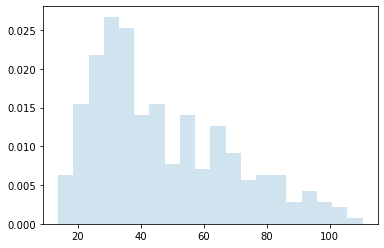

In [28]:
plt.hist(parallax_table['snr'],bins=20,histtype='stepfilled', alpha=0.2, density=True)



(array([0.060082  , 0.12016399, 0.15020499, 0.15020499, 0.36049198,
        0.60081996, 0.48065597, 0.72098395, 0.90122994, 0.75102495,
        0.42057397, 0.69094295, 0.30040998, 0.66090196, 0.69094295,
        0.57077896, 0.33045098, 0.39053297, 0.30040998, 0.18024599]),
 array([21.09650577, 21.20972973, 21.32295368, 21.43617763, 21.54940159,
        21.66262554, 21.77584949, 21.88907344, 22.0022974 , 22.11552135,
        22.2287453 , 22.34196926, 22.45519321, 22.56841716, 22.68164112,
        22.79486507, 22.90808902, 23.02131297, 23.13453693, 23.24776088,
        23.36098483]),
 [<matplotlib.patches.Polygon at 0x7f6f2957a190>])

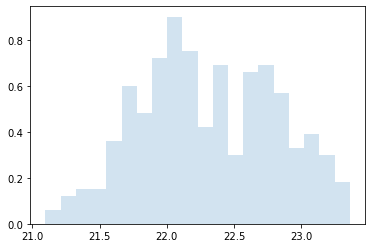

In [29]:
plt.hist(parallax_table['fiveSigmaDepth'],bins=20,histtype='stepfilled', alpha=0.2, density=True)

